>본 패키지는 Symbolic Music Generation용 Transformer 모델의 인퍼런스 과정 분석을 위해 제작되었습니다.

# Sequence Interpretation & Monitoring

- `inspector.monitoring.sequence_interpretation.SequenceInterpreter`와, 
- `inspector.monitoring.sequence_interpretation.InterpretedSequence`의 사용 예시 문서화를 위해 작성함

#### **CONTENTS:**

1. 준비

2. `SequenceInterpreter`와 `InterpretedSequence`
    
    * 2-1. 개요

    * 2-2. 편의 기능

3. `InterpretedSequence` 내부 위계 구조별 통계 추출 & 시각화 기능 소개

    * 3-1. Features

        * 3-1-1. `Logits` & `Probs`

        * 3-1-2. `SelfAttentionMap`
    
    * 3-2. Substructures

        * 3-2-1. `TokenHistory`와 토큰 `id` & 시퀀스 `index`

        * 3-2-2. `Item`
        
        * 3-2-3. `ItemUnion`

        * 3-2-3. `InterpretedSequence`

---------------------------------------------------------------------------
### 1. 준비:

먼저, 아래와 같이 분석이 필요한 샘플의 시퀀스와, info를 긁어옵니다 (.log 파일이든, 어디에서든).

In [1]:
input_info = {
    'genre': 'jazz',
    'key_signature': 'cmajor',
    'time_signature': '4/4',
    'bpm': 100,
    'track_category': 'main_melody',
    'pitch_range': 'mid_high',
    'rhythm': 'triplet',
    'is_incomplete_measure': False,
    'inst': 'acoustic_piano-1',
    'min_velocity': 2,
    'max_velocity': 127,
    'num_measures': 8,
    'chord_progression': [
        'Cmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7', 'Bm7b5', 'Bm7b5', 'E7(#9)(#13)', 'E7(#9)(#13)',
        'Am7', 'Am7', 'Am7', 'Am7','Gm7', 'Gm7','C7', 'C7',
        'Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7',
        'Dm7(9)', 'Dm7(9)', 'Dm7(9)', 'Dm7(9)', 'Gsus4', 'Gsus4', 'Gsus4', 'Gsus4',
        'Cmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7', 'Bm7b5', 'Bm7b5', 'E7(#9,#13)', 'E7(#9,#13)',
        'Am7', 'Am7', 'Am7', 'Am7', 'Gm7', 'Gm7', 'C7', 'C7',
        'Fmaj7', 'Fmaj7', 'Fmaj7', 'Fmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7', 'Cmaj7',
        'Dm7(9)', 'Dm7(9)', 'Dm7(9)', 'Dm7(9)', 'Gsus4', 'Gsus4', 'Gsus4', 'Gsus4'
    ],
    # guideline정보는 편의상 모두 "UNKNOWN"
}

generated_seq = [0, 767, 789, 814, 913, 821, 824, 925, 830, 917, 842, 844, 907, 941, 957, 977, 988, 1001, 579, 604, 711, 734, 591, 708, 722, 728, 597, 641, 715, 728, 579, 688, 720, 734, 591, 670, 718, 728, 597, 605, 711, 728, 579, 649, 716, 734, 591, 604, 711, 734, 579, 625, 713, 734, 591, 674, 718, 734, 579, 604, 711, 734, 591, 708, 722, 728, 597, 641, 715, 728, 579, 688, 720, 734, 591, 670, 718, 728, 597, 605, 711, 728, 579, 649, 716, 734, 591, 604, 711, 734, 579, 625, 713, 734, 591, 674, 718, 734, 2, 579, 604, 711, 734, 451, 166, 75, 217, 451, 166, 87, 217, 483, 167, 75, 214, 483, 167, 87, 214, 504, 165, 70, 205, 504, 165, 82, 205, 591, 708, 722, 728, 515, 171, 74, 225, 515, 171, 86, 225, 597, 641, 715, 728, 547, 167, 79, 224, 547, 167, 91, 224, 2, 579, 688, 720, 734, 451, 169, 75, 217, 451, 169, 87, 217, 483, 167, 75, 219, 483, 167, 87, 219, 504, 170, 70, 205, 504, 170, 82, 205, 591, 670, 718, 728, 515, 169, 75, 223, 515, 169, 87, 223, 597, 605, 711, 728, 547, 167, 79, 226, 547, 167, 91, 226, 2, 579, 649, 716, 734, 451, 167, 71, 217, 451, 167, 83, 217, 483, 166, 71, 215, 483, 166, 83, 215, 504, 167, 80, 205, 504, 167, 92, 205, 591, 604, 711, 734, 515, 170, 79, 227, 515, 170, 91, 227, 547, 166, 70, 226, 547, 166, 82, 226, 2, 579, 625, 713, 734, 451, 166, 75, 213, 451, 166, 87, 213, 483, 163, 75, 210, 483, 163, 87, 210, 504, 170, 72, 205, 504, 170, 84, 205, 591, 674, 718, 734, 515, 171, 77, 221, 515, 171, 89, 221, 547, 166, 70, 223, 547, 166, 82, 223, 2, 579, 604, 711, 734, 451, 166, 75, 217, 451, 166, 87, 217, 483, 167, 75, 214, 483, 167, 87, 214, 504, 165, 70, 205, 504, 165, 82, 205, 591, 708, 722, 728, 515, 171, 74, 225, 515, 171, 86, 225, 597, 641, 715, 728, 547, 167, 79, 224, 547, 167, 91, 224, 2, 579, 688, 720, 734, 451, 169, 75, 217, 451, 169, 87, 217, 483, 167, 75, 219, 483, 167, 87, 219, 504, 170, 70, 205, 504, 170, 82, 205, 591, 670, 718, 728, 515, 169, 75, 223, 515, 169, 87, 223, 597, 605, 711, 728, 547, 166, 79, 226, 547, 166, 91, 226, 2, 579, 649, 716, 734, 451, 170, 71, 217, 451, 170, 83, 217, 483, 169, 71, 215, 483, 169, 83, 215, 504, 170, 80, 205, 504, 170, 92, 205, 591, 604, 711, 734, 515, 169, 79, 227, 515, 169, 91, 227, 547, 166, 70, 226, 547, 166, 82, 226, 2, 579, 625, 713, 734, 451, 166, 75, 213, 451, 166, 87, 213, 483, 163, 75, 210, 483, 163, 87, 210, 504, 170, 72, 205, 504, 170, 84, 205, 591, 674, 718, 734, 515, 171, 77, 221, 515, 171, 89, 221, 547, 166, 70, 223, 547, 166, 82, 223, 1]

print(f"Length of sequence: {len(generated_seq)}")

Length of sequence: 507



분석하고자 하는 토큰 시퀀스와 해당 요청(메타) 정보, 그리고 분석 및 히스토리 복원에 사용할 체크포인트(경로)만 구비된다면 해당 패키지 내의 모든 기능을 사용할 수 있습니다.

*!! 주의사항: 위와 같이 **당시의 요청 `info`가 있어야 모든 기능을 사용할 수 있습니다**(특히 피아노롤 추출, 렌더링 기능).*

----------------------------------------------------------------------------------

### 2. `SequenceInterpreter`와 `InterpretedSequence`
    
- #### 2-1: 개요

`SequenceInterpreter`:

- 내부에 모델 체크포인트를 가지고 있습니다.

- 생성자의 `map_location` 변수로 모델 파라미터가 매핑되는 메모리 위치를 지정할 수 있습니다 ("cpu", "cuda:~" ...)

- `.interpret()` 메서드를 사용하면, 분석 및 히스토리 복원을 할 시퀀스를 모델에 태워 forward-evaluation을 한 뒤, 파생되는 결과들(`Logits`, `SelfAttentionMap`...)등을 `InterpretedSequence` 형태로 시퀀스와 함께 묶어 리턴합니다.

다음은 전체적인 준비 과정입니다:

1. 분석에 사용할 체크포인트 경로를 준비합니다 (시퀀스가 생성된 체크포인트여야 합니다).

2. 아래와 같이 생성자를 불러와 인스턴스화를 해주면, `interpreter.model`에 모델 인스턴스가 자동으로 매핑됩니다.

3. 주어진 `generated_seq`를 `interpreter.interpret()` 메서드에 `input_info`(생성 정보)와 함께 태워, `InterpretedSequence` 객체를 뽑습니다.

In [2]:
from midiai.inspector.monitoring.interpretation import SequenceInterpreter

checkpoint_path = (
    "/home/honggyu/workspace/dio_ai/data/inst_gen/"
    "best-step_37000-tl_0.6165-vl_0.7017.pt" 
)
interpreter = SequenceInterpreter(
    checkpoint_path=checkpoint_path,
    map_location="cpu",  # 이렇게 Jupyter를 이용한 interactive inspection 용도로는 cpu도 충분
    # map_location="cuda:0",
)
iseq = interpreter.interpret(generated_seq, info=input_info)

print(type(interpreter.model))
print(type(iseq))

Checkpoint Path: /home/honggyu/workspace/dio_ai/data/inst_gen/best-step_37000-tl_0.6165-vl_0.7017.pt
<class 'dioai.models.transformer_xl.MemTransformerLM'>
<class 'dioai.inspector.monitoring.interpretation.InterpretedSequence'>


이제, `.interpret()` 메서드의 결과인 `iseq`변수는 `InterpretedSequence` 타입이 되며, `.interpret()` 도중, 모델의 연산 결과로부터 얻은 값들을 (e.g., `Logits(Probs)`, `AttentionScores`, `mems` 등: 이하 *original feature*)을 내부에 저장하고 있습니다(이에 대해서는 다음 절부터 자세히 다룰 예정).

-------------------------------------------------------------------
- #### 2-2: 편의 기능

`InterpretedSequence`객체로 다음과 같은 몇 가지 편의기능을 사용할 수 있습니다.
- 첫 BAR 이후 토큰 시퀀스를 파싱하여 가독성 개선
- 피아노롤 파싱 및 이미지 형태로 플롯
- 오디오로 렌더링

0	: BAR_0: tensor([2])
1	: CHORD_0:        | pos: 0/24     |       -       | Cmaj7         | dur: 11/24    : tensor([579, 604, 711, 734])
2	: NOTE_0:         | pos: 0/128    | vel: 35/64    | C4            | dur: 22/256   : tensor([451, 166,  75, 217])
3	: NOTE_1:         | pos: 0/128    | vel: 35/64    | C5            | dur: 22/256   : tensor([451, 166,  87, 217])
4	: NOTE_2:         | pos: 32/128   | vel: 36/64    | C4            | dur: 19/256   : tensor([483, 167,  75, 214])
5	: NOTE_3:         | pos: 32/128   | vel: 36/64    | C5            | dur: 19/256   : tensor([483, 167,  87, 214])
6	: NOTE_4:         | pos: 53/128   | vel: 34/64    | G3            | dur: 10/256   : tensor([504, 165,  70, 205])
7	: NOTE_5:         | pos: 53/128   | vel: 34/64    | G4            | dur: 10/256   : tensor([504, 165,  82, 205])
8	: CHORD_1:        | pos: 12/24    |       -       | Bm7b5         | dur: 5/24     : tensor([591, 708, 722, 728])
9	: NOTE_6:         | pos: 64/128   | vel: 40/64    | B3 

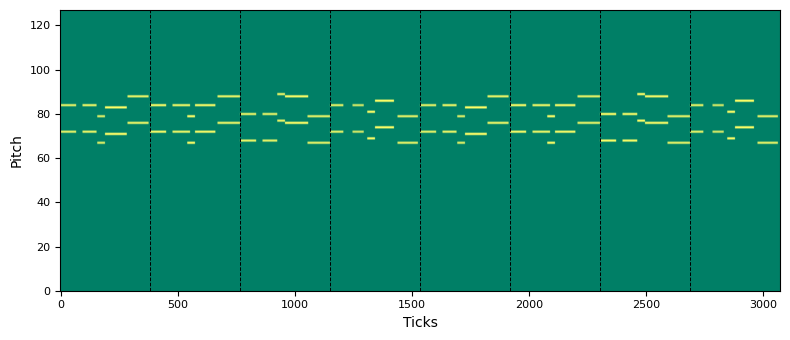

In [3]:
# Ex 1):
iseq.disp_items()

# Ex 2):
print(iseq.piano_roll().value.shape)
iseq.piano_roll().plot()

# Ex 3):
iseq.render()

----------------------------------------------------------------------------
#### 3. `InterpretedSequence` 객체와 내부 위계 구조별 통계 추출 & 시각화 기능 소개

* #### 3-1. Original features
        
    * 3-1-1 `Logits` & `Probs`

- 위의 `iseq` 변수는, raw_sequence인 `iseq.sequence`가 모델에 `forward()`되는 과정에서 파생되는 로짓값들을 `Logits`클래스 형태로 `.logits` 속성에 저장하고 있습니다.

- iseq에 기본 지정된 `iseq.prob_func` 함수와 `iseq.sampling_func` 함수를 통해, `iseq.logits`로부터 `iseq.probs` 속성에 `Probs` 클래스의 확률값 객체를 저장합니다.

In [4]:
from midiai.inspector.monitoring.utils import TextColors as TC
from midiai.inspector.monitoring.vocab_utils import vocab

print(f"{TC.GREEN}* Length of iseq.sequence: {len(iseq.sequence)}{TC.ENDC}")
print(f"{TC.GREEN}* Current vocabulary size: {vocab.vocab_size}{TC.ENDC}\n")

print(f"* logits -> raw probs func: {TC.GREEN}{iseq.prob_func}{TC.ENDC}")
print(f"* raw probs -> sampled probs func: {TC.GREEN}{iseq.sampling_func}{TC.ENDC}\n")

print(f"* Type of iseq.logits: {iseq.logits}")  # .value 속성에 값 자체가 저장됨
print(f"{TC.GREEN}* Shape of iseq.logits.values: {iseq.logits.value.shape}\n{TC.ENDC}")

print(f"* Type of iseq.logits: {iseq.probs}")  # .value 속성에 값 자체가 저장됨
print(f"{TC.GREEN}* Shape of iseq.probs.value: {iseq.probs.value.shape}\n{TC.ENDC}")

print(f"")

* Length of iseq.sequence: 507
* Current vocabulary size: 1003

* logits -> raw probs func: functools.partial(<function temperatured_softmax at 0x7f5c554c4ee0>, temperature=0.95)
* raw probs -> sampled probs func: functools.partial(<function top_k at 0x7f5c554c4f70>, k=32)

* Type of iseq.logits: Feature type 'Logits', shape of value: torch.Size([506, 1003])
* Shape of iseq.logits.values: torch.Size([506, 1003])

* Type of iseq.logits: Feature type 'Probabilities', shape of value: torch.Size([506, 1003])
* Shape of iseq.probs.value: torch.Size([506, 1003])



- `Logits`와 `Probs` 클래스는, `.slice()` 메서드를 이용해 내부 `.value`의 슬라이싱 된 버전을 사용 가능합니다.

In [5]:
logits = iseq.logits
probs = iseq.probs

# Ex 1): 일반 슬라이싱
print(
    logits.slice(row=[100, 101, 101]).value.shape
)

# Ex 2): slice객체를 이용한 슬라이싱
print(
    probs.slice(row=slice(0, 200, 2), col=slice(100, 500, 2)).value.shape
)

# Ex 3): row 및 col axis의 토큰카테고리(필드) 별 슬라이싱
from midiai.inspector.monitoring.vocab_utils import TokenFields as TF
print(
    logits.slice(row=TF.PITCH, col=467).value.shape
)  # row-방향의 pitch 토큰 히스토리 중 467번 확률값만 모음

# Ex 4): 다중 슬라이싱
print(
    probs.slice(row=TF.NOTE_DURATION, col=TF.NOTE_DURATION).slice(row=0).value.shape
)  # row/col 방향으로 NOTE_DURATION 필드만 모은 뒤, 첫 번째 row를 열람

torch.Size([3, 1003])
torch.Size([100, 200])
torch.Size([80])
torch.Size([256])


- `.disp()`와 `.plot()`을 이용해 시각화 기능을 제공합니다.
    * 요청된 시각화 갯수가 20개를 넘으면 노트북에 표시하기엔 너무 많으므로 진행할 지 말지 결정할 수 있습니다.

row 0:
0	: <NOTE_POSITION>  | pos: 0/128     (id: 451)	| 0.8999	| p_sum: 0.899923
1	: <NOTE_POSITION>  | pos: 1/128     (id: 452)	| 0.0271	| p_sum: 0.927057
2	: <NOTE_POSITION>  | pos: 32/128    (id: 483)	| 0.0245	| p_sum: 0.951559
3	: <NOTE_POSITION>  | pos: 31/128    (id: 482)	| 0.0080	| p_sum: 0.959548
4	: <CHORD_POSITION> | pos: 12/24     (id: 591)	| 0.0077	| p_sum: 0.967219
5	: <NOTE_POSITION>  | pos: 2/128     (id: 453)	| 0.0066	| p_sum: 0.973794

row 1:
0	: <NOTE_POSITION>  | pos: 0/128     (id: 451)	| 0.6809	| p_sum: 0.680867
1	: <NOTE_POSITION>  | pos: 21/128    (id: 472)	| 0.1278	| p_sum: 0.808649
2	: <NOTE_POSITION>  | pos: 32/128    (id: 483)	| 0.1097	| p_sum: 0.918381
3	: <NOTE_POSITION>  | pos: 24/128    (id: 475)	| 0.0208	| p_sum: 0.939207
4	: <NOTE_POSITION>  | pos: 1/128     (id: 452)	| 0.0127	| p_sum: 0.951923
5	: <NOTE_POSITION>  | pos: 22/128    (id: 473)	| 0.0119	| p_sum: 0.963792
6	: <NOTE_POSITION>  | pos: 53/128    (id: 504)	| 0.0084	| p_sum: 0.972219
7	: <NOTE_

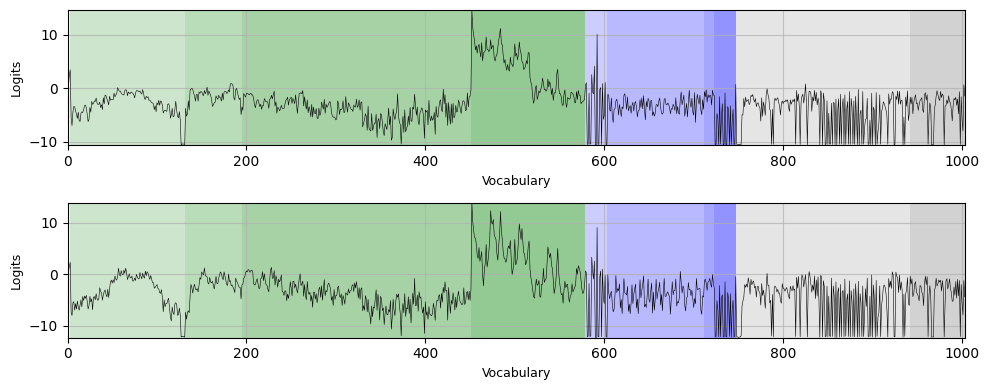

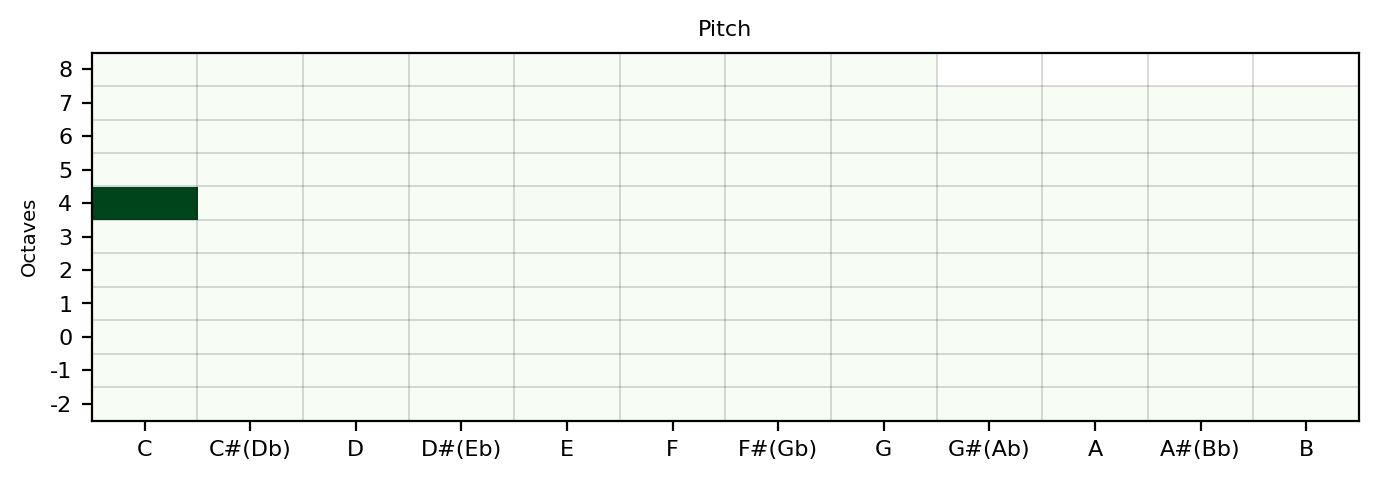

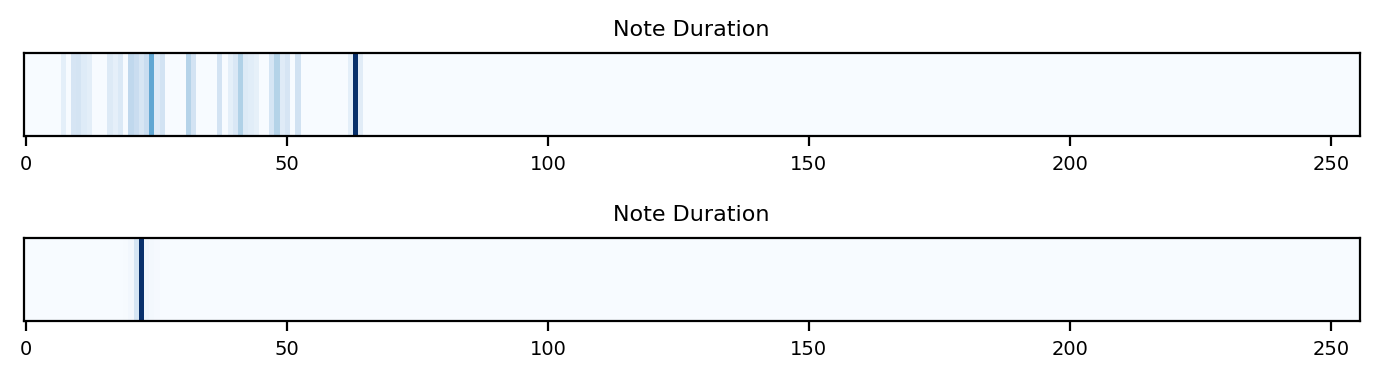

In [6]:
# Ex 1): 확률의 NOTE_POSITION row 슬라이싱 후, 첫 번째 확률값들 중 0.05보다 큰 값만 display
probs.slice(row=TF.NOTE_POSITION).slice(row=slice(0, 2)).disp(threshold=0.005)

# Ex 1): 로짓의 NOTE_POSITION 해당 row 슬라이싱 후 첫 두개만 plot
# 초록색 배경은 sequence_word, 푸른색 배경은 chord_word, 회색 배경은 그 외 필드임(메타, 가이드)
logits.slice(row=TF.NOTE_POSITION).slice(row=slice(0, 2)).plot()

# Ex 2): 확률의 PITCH 해당 row 슬라이싱 후 PITCH 범위 확률들만 pitch-matrix로 plot
probs.slice(row=TF.PITCH).slice(row=slice(12, 13)).plot(field=TF.PITCH)

# Ex 2): 확률의 NOTE_DURATION 해당 row 슬라이싱 후 NOTE_DURATION 범위 확률들만 bar-code로 plot
probs.slice(row=TF.NOTE_DURATION).slice(row=slice(0, 2)).plot(field=TF.NOTE_DURATION)

- `Probs`클래스의 경우, 몇 가지 종류의 확률 관련 메트릭 계산 루틴을 지원합니다 (슬라이싱 이후에도 사용 가능).

- 계산 루틴의 인자에 `values_only=True`를 주면, 플로팅을 메서드를 지닌 파생 클래스로 리턴하지 않고 빠르게 값만 리턴 가능합니다.

<class 'dioai.inspector.monitoring.features.TimeSeries'>
tensor(0.4982)


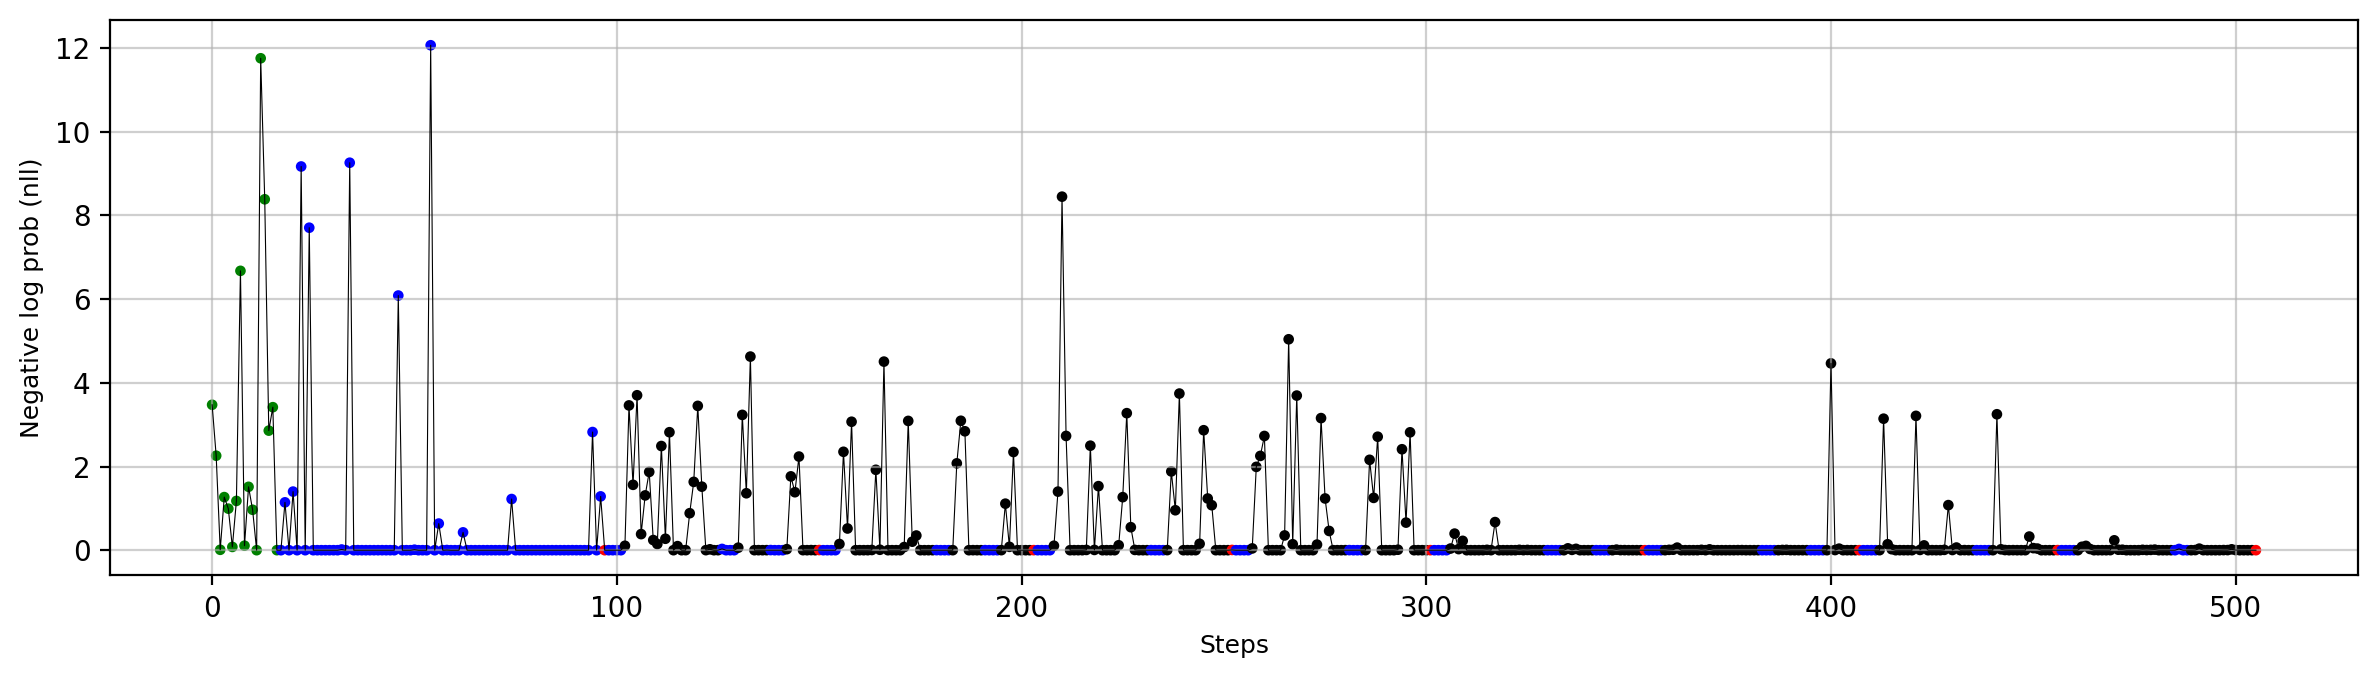

<class 'dioai.inspector.monitoring.features.TimeSeries'>
torch.Size([80])


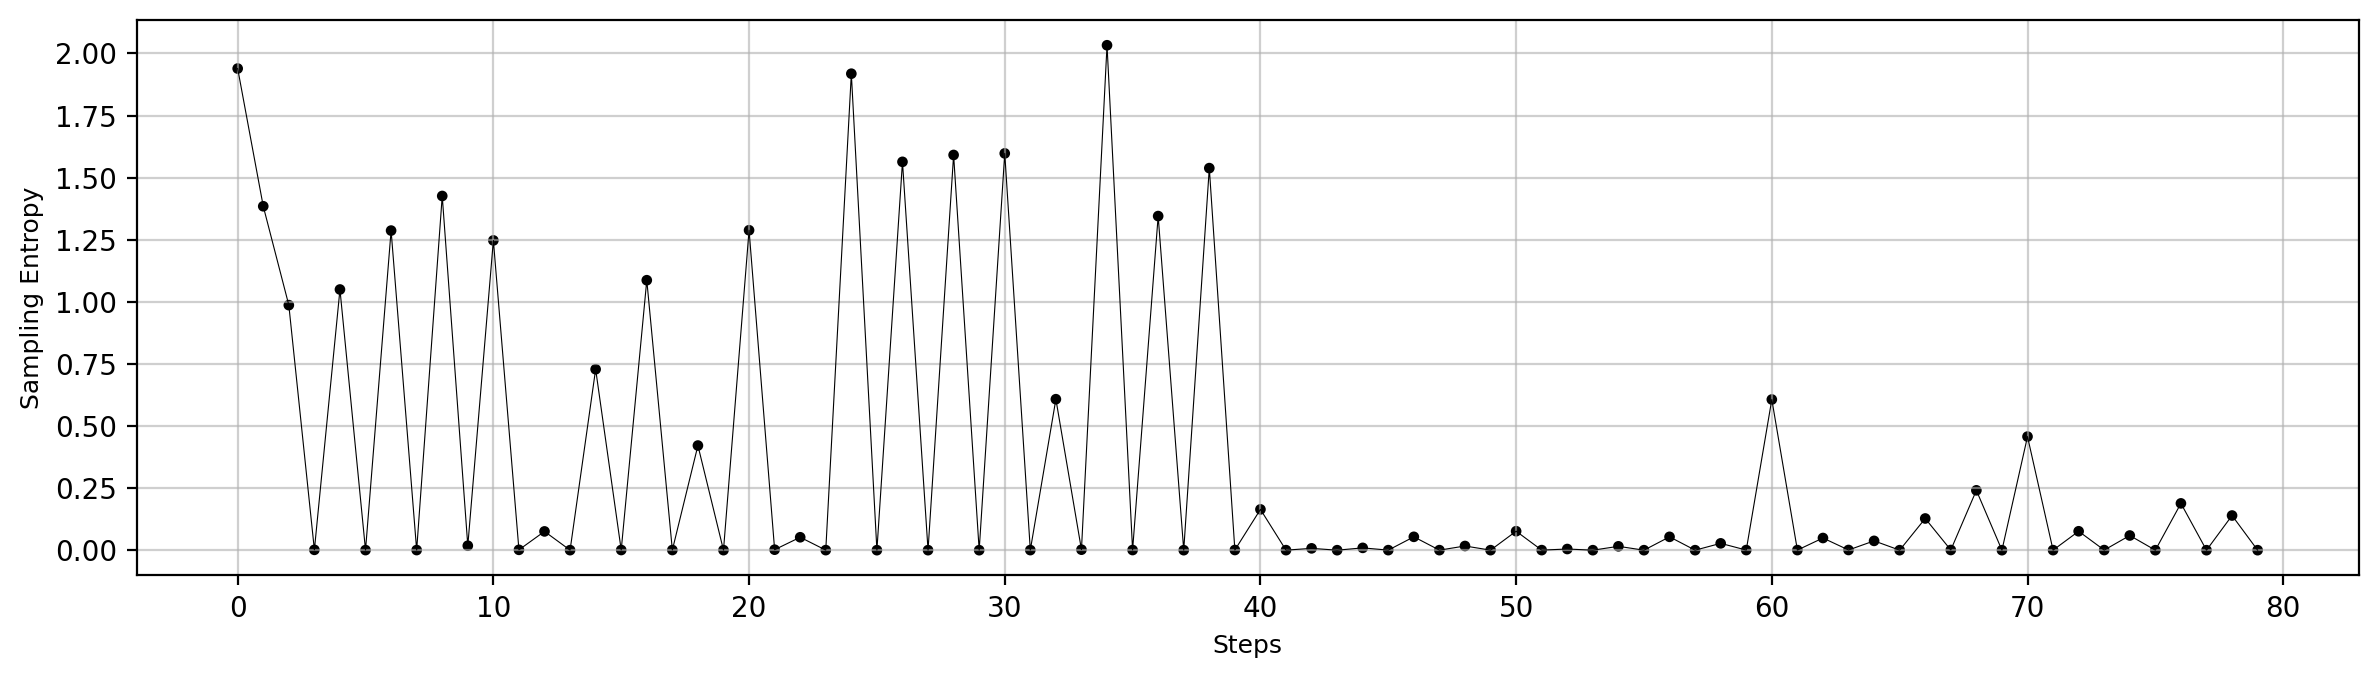

tensor([1.0000, 0.9965, 0.9988, 0.9940, 0.9992, 0.9999, 0.9996, 0.9978])

In [7]:
# Ex 1): target nll 계산 (TimeSeries 형태의 클래스로 리턴됨)
print(type(probs.target_nll()))
print(
    probs.target_nll().value.mean()  # 통상적인 시퀀스의 negative log loss 값
)
probs.target_nll().plot()  # (초록 점은 meta(& guide), 푸른 점은 chord, 검은 점은 note, 붉은 점은 bar, eos)

# Ex 2): stepwise entropy 계산 (역시 TimeSeries 형태의 클래스로 리턴됨)
print(type(probs.stepwise_entropy()))
print(
    probs.slice(TF.PITCH).stepwise_entropy(values_only=True).shape  # values_only로 값만 빠르게 리턴 가능
)

# Ex 3): pitch 들만의 샘플링 엔트로피를 플롯: 
probs.slice(TF.PITCH).stepwise_entropy().plot()
# 전체 마디 절반 이후 반복되는 패턴이 등장하며, 엔트로피가 낮아짐 (확신을 갖고 샘플링)

# Ex 4): 시퀀스가 샘플링 된 확률값들의 시계열(stepwise) 값만 리턴
probs.slice(TF.BAR).target_probabilities(values_only=True)

------------------------------------------------------------------------------
* ##### 3-1-2: `SelfAttentionMap`(어텐션 스코어)

이 경우는 모델의 레이어 및 어텐션 헤드 별로 하나씩 맵이 생기기 때문에, (layer x head x seq_len x seq_len) 4차원 텐서로 저장됩니다.

In [8]:
print(f"{TC.GREEN}* Length of iseq.sequence: {len(iseq.sequence)}\n{TC.ENDC}")

print(f"* Type of iseq.self_attention_map: {iseq.self_attention_map}")
print(f"{TC.GREEN}* Shape of iseq.self_attentions_map.value: {iseq.self_attention_map.value.shape}{TC.ENDC}")
# (layers x head x seq_len x seq_len)

* Length of iseq.sequence: 507

* Type of iseq.self_attention_map: Feature type 'Self Attention Map', shape of value: torch.Size([10, 10, 507, 507])
* Shape of iseq.self_attentions_map.value: torch.Size([10, 10, 507, 507])


`Logits`, `Probs`와 동일하게 `.slice()` 메서드를 제공하고, `layer`와 `head`인자가 존재하여, 

- 몇 번째 layer와 head에서 온 어텐션인지 선택할 수 있습니다. 

- 각각 인자를 넣지 않으면 해당 dimension으로 summation을 하여 리턴합니다.

In [9]:
map = iseq.self_attention_map

# Ex 1): 레이어, 헤드 방향 summation을 한 후 full-map을 조회 
print(
    map.slice().value.shape
)
# Ex 2): index 0 레이어, index 2 헤드의 full-map을 조회
print(
    map.slice(layer=0, head=2).value.shape
)
# Ex 3): 레이어, 헤드 방향 summation을 한 후, PITCH 토큰에 해당하는 query만 모든 map을 조회
print(
    map.slice(query=TF.PITCH).value.shape
)
# Ex 4): 레이어, 헤드 방향 summation을 한 후, PITCH query 중 같은 PITCH key에 대한 스코어만을 조회
print(
    map.slice(query=TF.PITCH, key=TF.PITCH).value.shape
)

torch.Size([507, 507])
torch.Size([507, 507])
torch.Size([80, 507])
torch.Size([80, 80])


마찬가지로, 어텐션 맵을 `.plot()` 메서드로 플로팅 할 수 있습니다.

- `.slice()`를 반드시 사용하여 2차원으로 줄여주어야 합니다. 그렇지 않으면 에러를 리턴합니다.

- `.slice()`이후의 결과가 1차원이라면 2D 이미지 플롯 대신 key축을 x-축으로 삼아 line-plot을 실시합니다. 이 때, `Logits` 및 `Probs`와는 다르게 아직은 key 축의 토큰 필드 당 색 하이라이팅을 지원하지 않습니다.

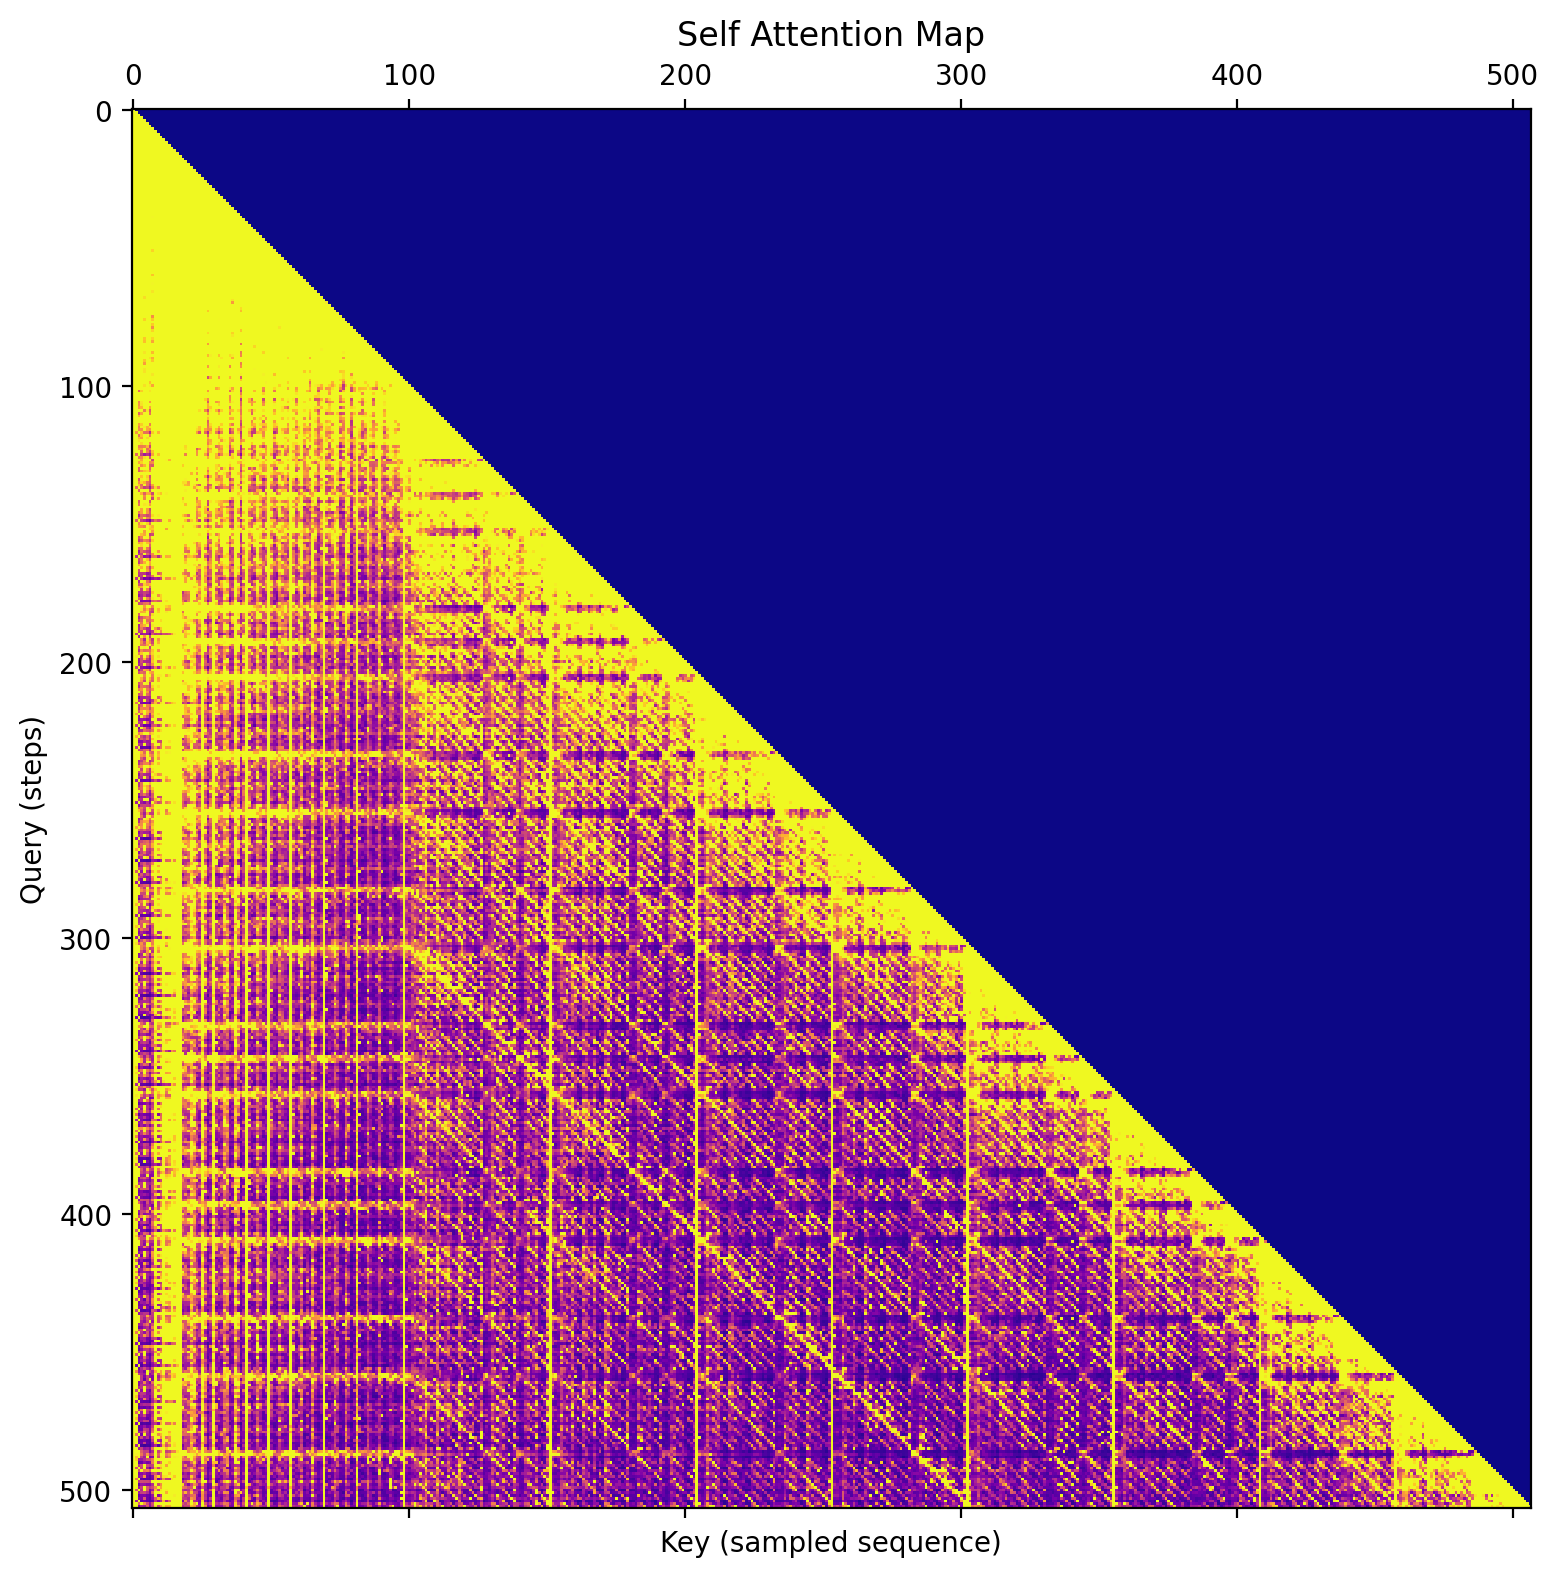

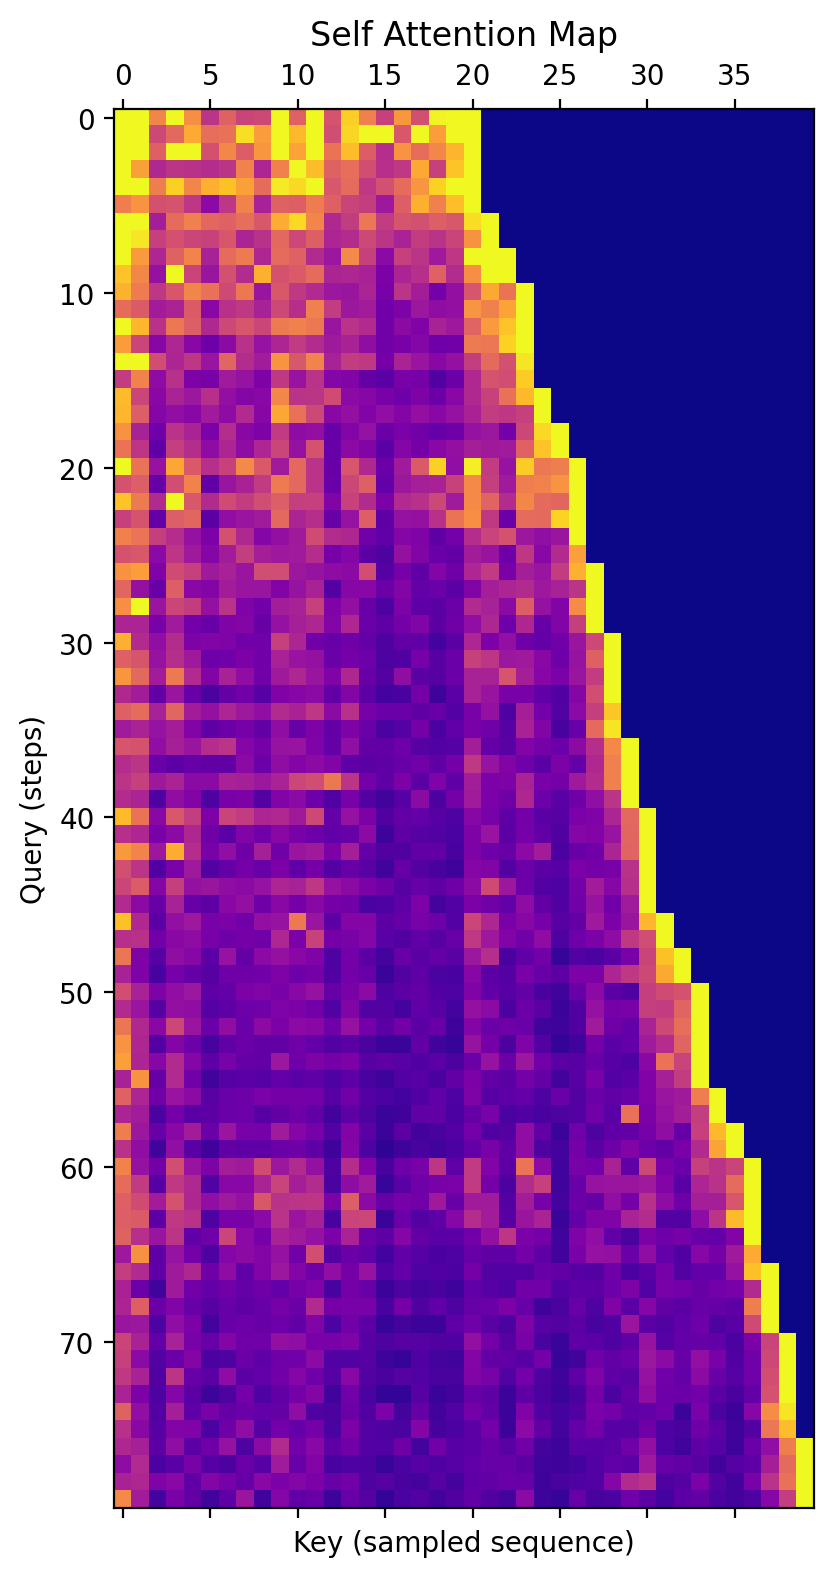

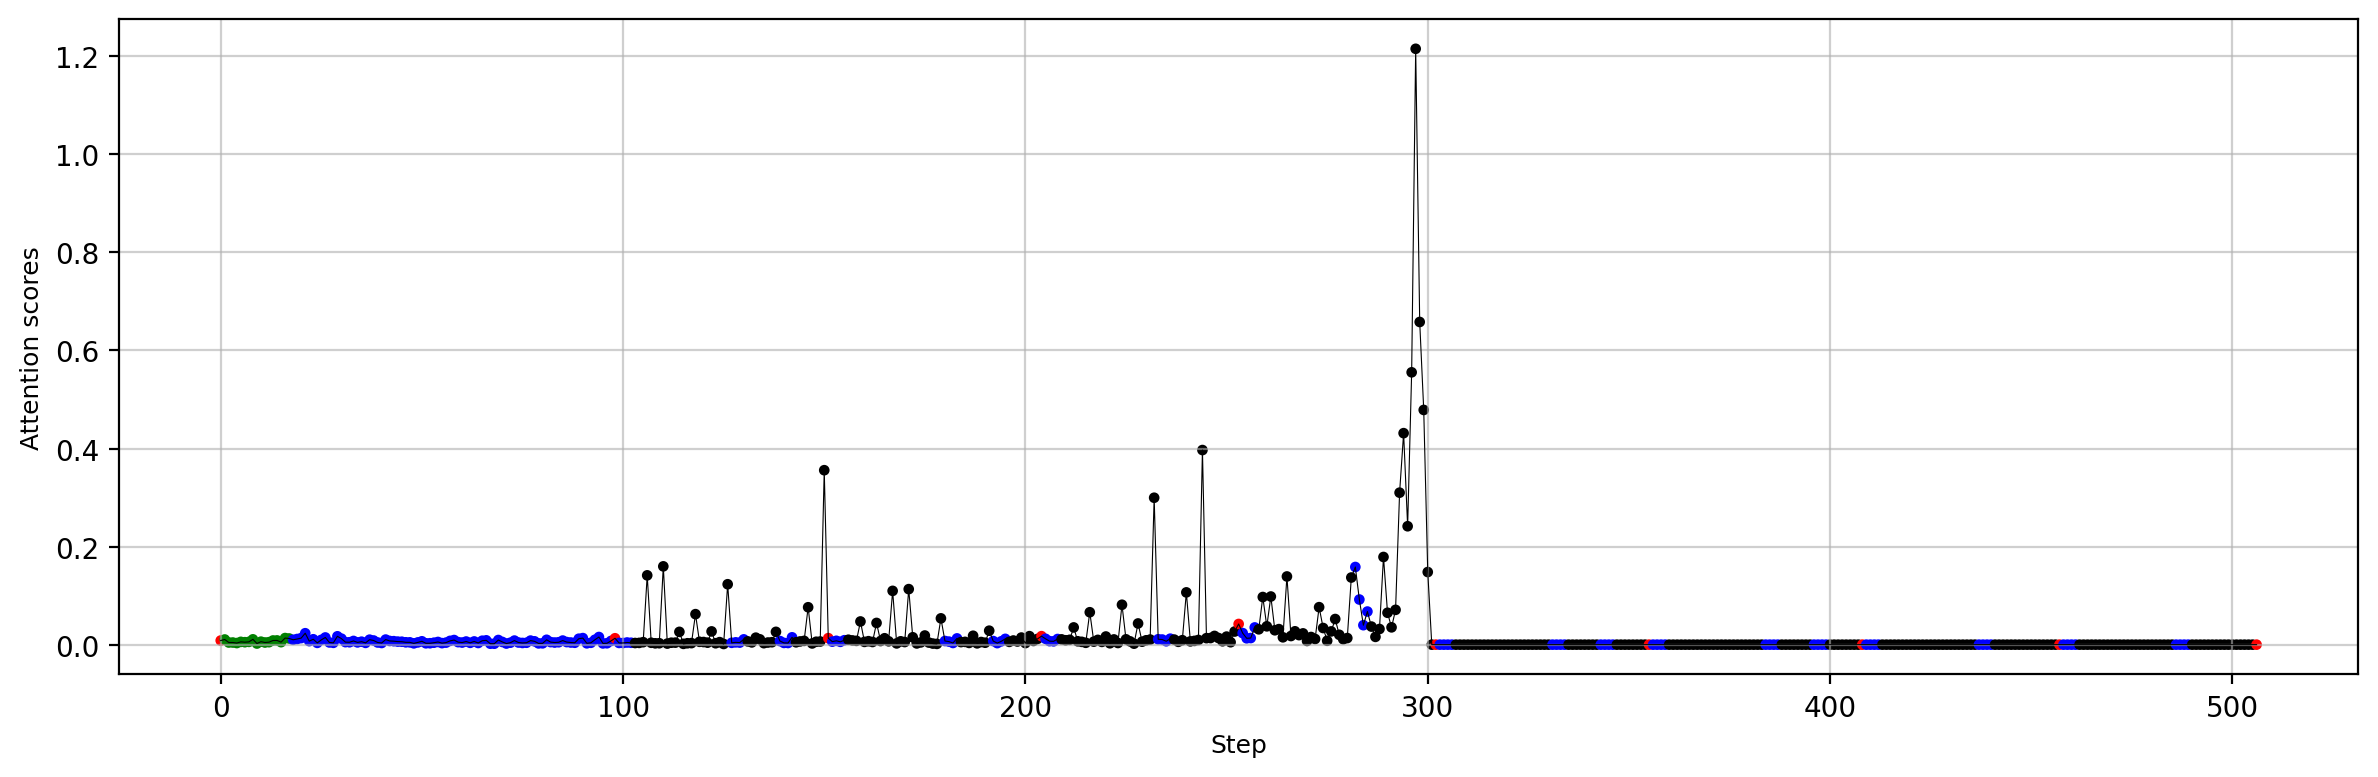

In [10]:
# Ex 1): 레이어, 헤드 방향 summation을 한 후 full-map을 플롯
map.slice().plot()

# Ex 2): 레이어, 헤드 방향 summation을 한 후, PITCH 토큰 샘플링 시 CHORD토큰에 대한 스코어를 플롯
map.slice(query=TF.PITCH, key=TF.CHORD).plot()  # 생각보다 영향이 많이 없을지도

# Ex 3): 2 번째 레이어의 헤드 방향 summation을 한 후, 300번째 토큰 생성시 전체 key에 대한 어텐션 스코어를 플롯
map.slice(layer=2, query=300).plot()

----------------------------------------------------------------------
* #### 3-2. Substructures
    * ##### 3-2-1. `TokenHistory`와 토큰 `id` & 시퀀스 `index`

`InterpretedSequence`로부터 파생되는 substructure 클래스들을 다룰 예정입니다. 다음과 같이 총 3가지가 있고, 

- `TokenHistory`
- `Item`
- `ItemUnion`

첫 번째는 개별 token history substructure입니다. `.id`와 `.index` 속성을 갖게 되며,

- `id`는 토큰 번호,
- `index`는 원래 raw 시퀀스(`iseq.sequence`)에서의 인덱스 위치를 나타냅니다.

Original feature인 `Logits`, `Probs`, `SelfAttentionMap`을 모두 지니고 있습니다.

NOTE_POSITION   : | pos: 64/128    (id: 515)
VELOCITY        : | vel: 40/64     (id: 171)
PITCH           : | D4             (id: 77)
NOTE_DURATION   : | dur: 26/256    (id: 221)
NOTE_POSITION   : | pos: 64/128    (id: 515)
VELOCITY        : | vel: 40/64     (id: 171)
PITCH           : | D5             (id: 89)
NOTE_DURATION   : | dur: 26/256    (id: 221)
NOTE_POSITION   : | pos: 96/128    (id: 547)
VELOCITY        : | vel: 35/64     (id: 166)
PITCH           : | G3             (id: 70)
NOTE_DURATION   : | dur: 28/256    (id: 223)
NOTE_POSITION   : | pos: 96/128    (id: 547)
VELOCITY        : | vel: 35/64     (id: 166)
PITCH           : | G4             (id: 82)
NOTE_DURATION   : | dur: 28/256    (id: 223)
EOS             : EOS              (id: 1)

1
506
TokenFields.EOS
torch.Size([1003])
torch.Size([1003])
torch.Size([10, 10, 507]) 

TokenFields.VELOCITY
tensor(2.3516)
2.351137399673462


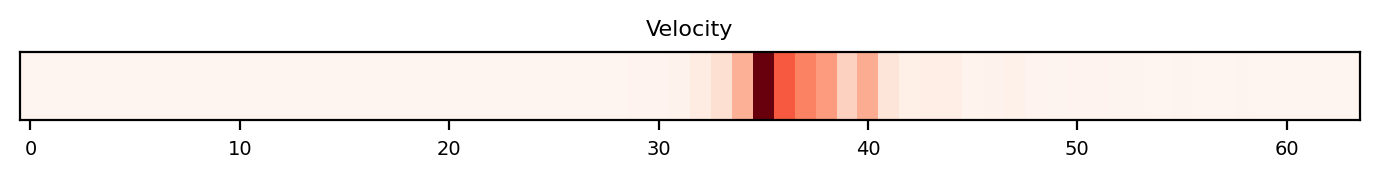

In [11]:
tokens = iseq.tokens

# Ex 1): 개별 토큰들의 repr
for token in tokens[-17:]:
    print(token)
print("")

# Ex 2): 특정 토큰히스토리 정보 열람
print(tokens[-1].id)
print(tokens[-1].index)
print(tokens[-1].field)
print(tokens[-1].logits.value.shape)
print(tokens[-1].probs.value.shape)
print(tokens[-1].self_attention_map.value.shape, "\n")

# Ex 3): original features 메서드 사용예
print(tokens[157].field)
print(
    tokens[157].probs.target_nll(values_only=True)
)
print(
    tokens[157].probs.stepwise_entropy(values_only=True)
)
tokens[157].probs.plot(TF.VELOCITY)


--------------------------------------------------------------------
* ##### 3-2-2. `Item`

`TokenHistory` 객체가 하나의 의미단위 (Note, Chord, Bar, Eos)등으로 모여 이루는 객체입니다.

내부의 `TokenHistory`들로부터 파생된 ids, indices 등의 속성을 지니고 있고, 해당하는 `Feature`들도 역시 파생됩니다.

<class 'dioai.inspector.monitoring.substructures.items.Note'>
NOTE_20:        | pos: 0/128    | vel: 36/64    | G#(Ab)3       | dur: 22/256   : tensor([451, 167,  71, 217])
tensor([451, 167,  71, 217])
tensor([209, 210, 211, 212])
[<TokenFields.NOTE_POSITION: 'NOTE_POSITION'>, <TokenFields.VELOCITY: 'VELOCITY'>, <TokenFields.PITCH: 'PITCH'>, <TokenFields.NOTE_DURATION: 'NOTE_DURATION'>]
tensor([8.9910e-01, 2.4657e-01, 2.1413e-04, 6.5158e-02])
Selected item:| NOTE_20:        | pos: 0/128    | vel: 36/64    | G#(Ab)3       | dur: 22/256   : tensor([451, 167,  71, 217])


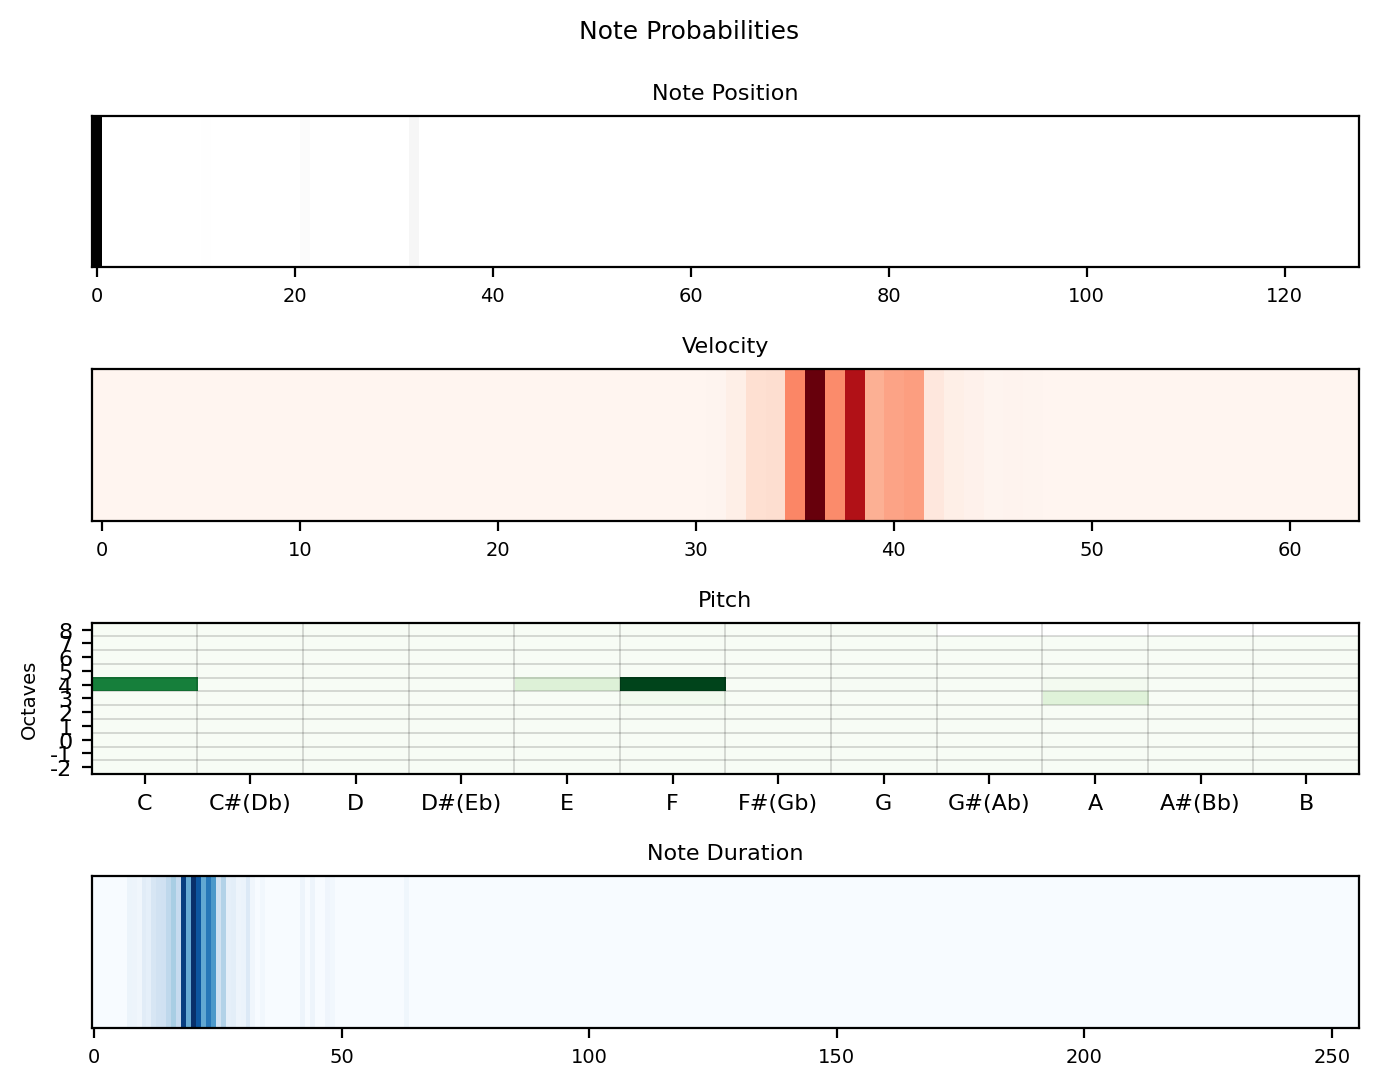

In [12]:
item = iseq.items[30]  # Fmaj7에서 Ab불협을 낸 특정 item 추출

print(type(item))
print(item)
print(item.ids)
print(item.indices)
print(item.fields)
print(item.probs.target_probabilities(values_only=True))

item.plot_probs()  # 각 토큰들의 feature를 한 번에 플롯

--------------------------------------------------------------------
* ##### 3-2-3. `ItemUnion`

`Item` 객체들이 특정 기준 아이템(lead item) 단위로 모여 이루는 객체입니다. 현재는

- `Bar`기준으로 나눈 `BarUnion`,
- `Chord` 기준으로 나눈 `HarmonicUnion`

두 가지를 사용할 수 있습니다.

내부의 `Item`들로부터 파생된 ids, indices 등의 속성을 지니고 있고, 해당하는 `Feature`들도 역시 파생됩니다.

`BarUnion`을 먼저 보겠습니다. Unique한 통계 루틴으로 onset 추출 메서드가 있습니다.

<class 'dioai.inspector.monitoring.substructures.itemunions.BarUnion'>
BAR_2: tensor([2])
CHORD_6:        | pos: 0/24     |       -       | Fmaj7         | dur: 11/24    : tensor([579, 649, 716, 734])
NOTE_20:        | pos: 0/128    | vel: 36/64    | G#(Ab)3       | dur: 22/256   : tensor([451, 167,  71, 217])
NOTE_21:        | pos: 0/128    | vel: 36/64    | G#(Ab)4       | dur: 22/256   : tensor([451, 167,  83, 217])
NOTE_22:        | pos: 32/128   | vel: 35/64    | G#(Ab)3       | dur: 20/256   : tensor([483, 166,  71, 215])
NOTE_23:        | pos: 32/128   | vel: 35/64    | G#(Ab)4       | dur: 20/256   : tensor([483, 166,  83, 215])
NOTE_24:        | pos: 53/128   | vel: 36/64    | F4            | dur: 10/256   : tensor([504, 167,  80, 205])
NOTE_25:        | pos: 53/128   | vel: 36/64    | F5            | dur: 10/256   : tensor([504, 167,  92, 205])
CHORD_7:        | pos: 12/24    |       -       | Cmaj7         | dur: 11/24    : tensor([591, 604, 711, 734])
NOTE_26:        | pos:

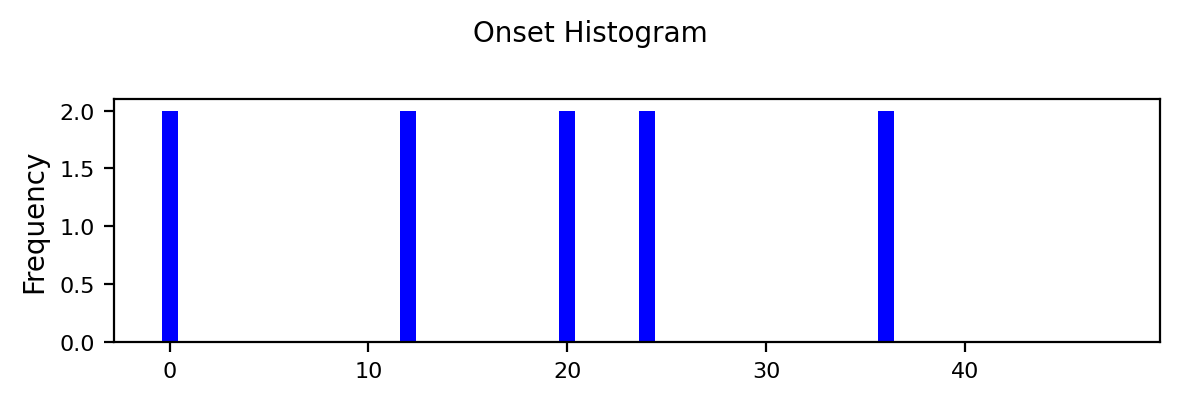

In [13]:
union = iseq.bar_unions[2]  # 특정 bar 추출

print(type(union))
print(union)
print(union.ids)
print(union.fields)
print(union.probs.target_probabilities(values_only=True))
print(union.indices, "\n\n")

# union.plot_probs()  # 각 토큰들의 feature를 한 번에 플롯

# onset 추출
print(union.onsets(resolution=48, values_only=True).shape)
union.onsets().plot()  # 마디 내 onset들을 플롯

다음은 `HarmonicUnion` 입니다. Unique한 통계 추출 루틴으로 pitch class histogram 추출 메서드가 있습니다.

<class 'dioai.inspector.monitoring.substructures.itemunions.HarmonicUnion'>
CHORD_8:        | pos: 0/24     |       -       Dm7(9)          | dur: 11/24    : tensor([579, 625, 713, 734])
NOTE_30:        | pos: 0/128    | vel: 35/64    | C4            | dur: 18/256   : tensor([451, 166,  75, 213])
NOTE_31:        | pos: 0/128    | vel: 35/64    | C5            | dur: 18/256   : tensor([451, 166,  87, 213])
NOTE_32:        | pos: 32/128   | vel: 32/64    | C4            | dur: 15/256   : tensor([483, 163,  75, 210])
NOTE_33:        | pos: 32/128   | vel: 32/64    | C5            | dur: 15/256   : tensor([483, 163,  87, 210])
NOTE_34:        | pos: 53/128   | vel: 39/64    | A3            | dur: 10/256   : tensor([504, 170,  72, 205])
NOTE_35:        | pos: 53/128   | vel: 39/64    | A4            | dur: 10/256   : tensor([504, 170,  84, 205])

tensor([579, 625, 713, 734, 451, 166,  75, 213, 451, 166,  87, 213, 483, 163,
         75, 210, 483, 163,  87, 210, 504, 170,  72, 205, 504, 170, 

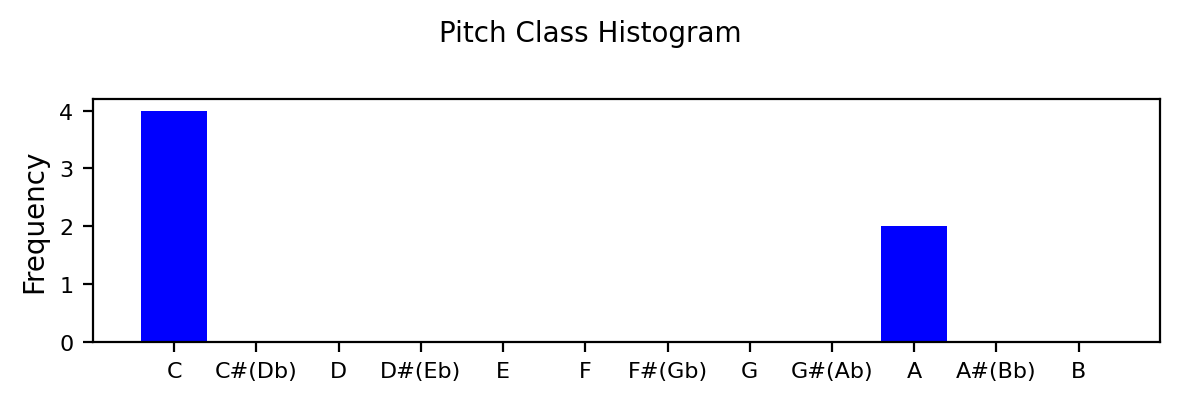

In [14]:
union = iseq.harmonic_unions[8]  # 특정 chord 추출

print(type(union))
print(union)
print(union.ids)
print(union.fields)
print(union.probs.target_probabilities(values_only=True))
print(union.indices, "\n\n")

# union.plot_probs()  # 각 토큰들의 feature를 한 번에 플롯

# onset 추출
print(union.get_pitch_class_histogram(values_only=True))
union.get_pitch_class_histogram().plot()  # 마디 내 pitch class들을 플롯

--------------------------------------------------------------------
* ##### 3-2-4. `ParsedSequence`

마지막으로 돌아와서, 전체 시퀀스 스트럭처인 `ParsedSequence`만이 추출할 수 있는 파생 feature들도 있습니다 (현재는 Grooving pattern similarity 뿐).

<class 'dioai.inspector.monitoring.features.BarUnionFeatureMatrix'>
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


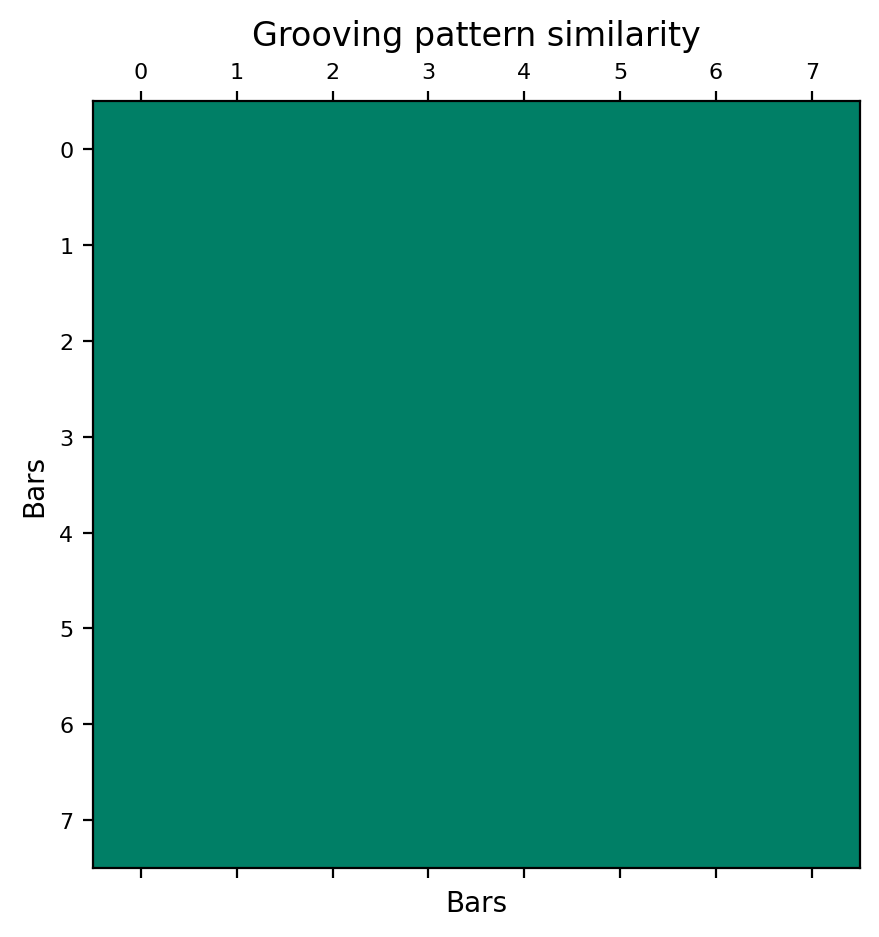

In [15]:
gps = iseq.grooving_pattern_similarity()

print(type(gps))
print(gps.value)  # 각 bar의 groove가 모두 같아, 유사도가 모두 1이 나옴.
gps.plot()